# Noise2Void - 2D Example for SEM data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import urllib

import os
import zipfile
from tifffile import imread

In [3]:
from n2v.utils import plot_some, plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.models import Config, CARE

## Download data
Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter

Thanks!


In [4]:
# Download data
os.system("rm -r data")
if not os.path.isdir('./data'):
    os.mkdir('./data')

zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/ge0Pacw4gZ5Ckww/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [5]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = Config('SYXC', n_channel_in=1, n_channel_out=1, unet_kern_size = 3, train_steps_per_epoch=10, train_loss='mse',
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 128, n2v_num_pix = 64,
                n2v_patch_shape = (64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5')

vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 64,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5'}

In [7]:
model = CARE(config, 'n2v_2D', basedir='models')

/home/coreys/Noise2Void/n2v/n2v/models/care_standard.py:118: UserWarning: output path for model already exists, files may be overwritten: /home/coreys/Noise2Void/n2v/examples/2D/models/n2v_2D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

In [8]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

def extractRandomPatches(inp, size, number):
    results=[]
    for i in range(number):
        x=np.random.randint(0,inp.shape[2]-size)
        y=np.random.randint(0,inp.shape[1]-size)
        z=np.random.randint(0,inp.shape[0])
        patch=inp[z,y:y+size,x:x+size].copy()
        results.append(patch)
    return np.array(results)

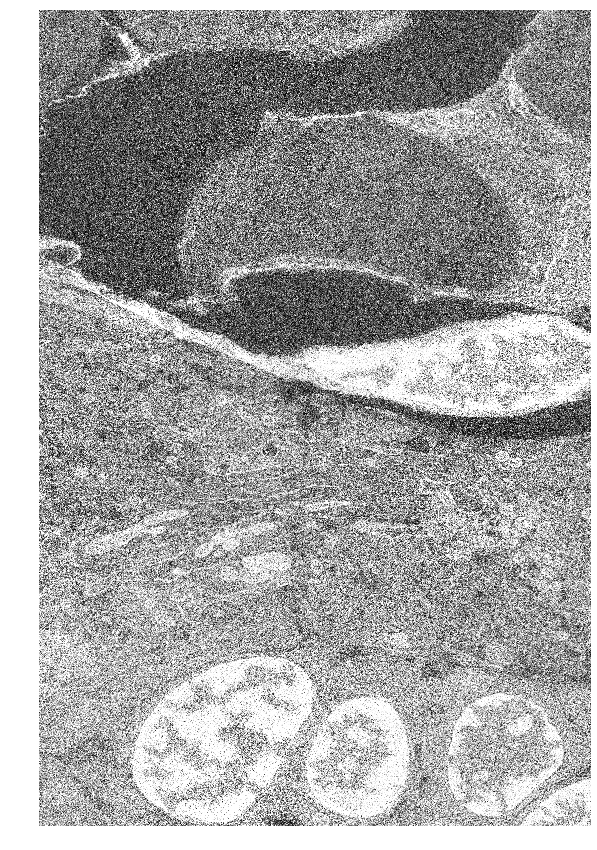

In [9]:
# Load lowSNR data. Note: This can be the same data as we test on. 
# We are only using a sinlge slice (the 3rd), and cut away some part to reserve the rest for validation
plt.figure(figsize=(15,15))
X = imread('data/SEM/train/train.tif')[np.newaxis,3,:2500,:].astype(np.float32)
plt.imshow(X[0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [10]:
# We are extracting random patches
X = extractRandomPatches(X,64,512)
X = X[...,np.newaxis]
print(X.shape)

(512, 64, 64, 1)


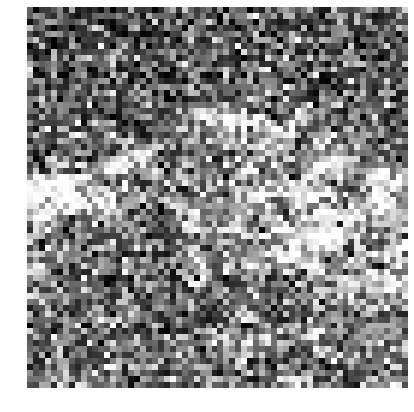

(512, 64, 64, 1) (512, 64, 64, 2)


In [11]:
mean, std = np.mean(X), np.std(X)
X = normalize(X, mean, std)

# We concatenate an extra channel filled with zeros. It will be internally used for the masking.
Y = np.concatenate((X, np.zeros(X.shape)), axis=3)

# All training images are noisy:
plt.figure(figsize=(7,7))
plt.imshow(Y[0,...,0], cmap=plt.cm.gray)
plt.axis('off')
plt.show()
print(X.shape, Y.shape)

### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

/home/coreys/Noise2Void/n2v/n2v/utils/n2v_utils.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return patch[slices]


(256, 64, 64, 1) (256, 64, 64, 2)


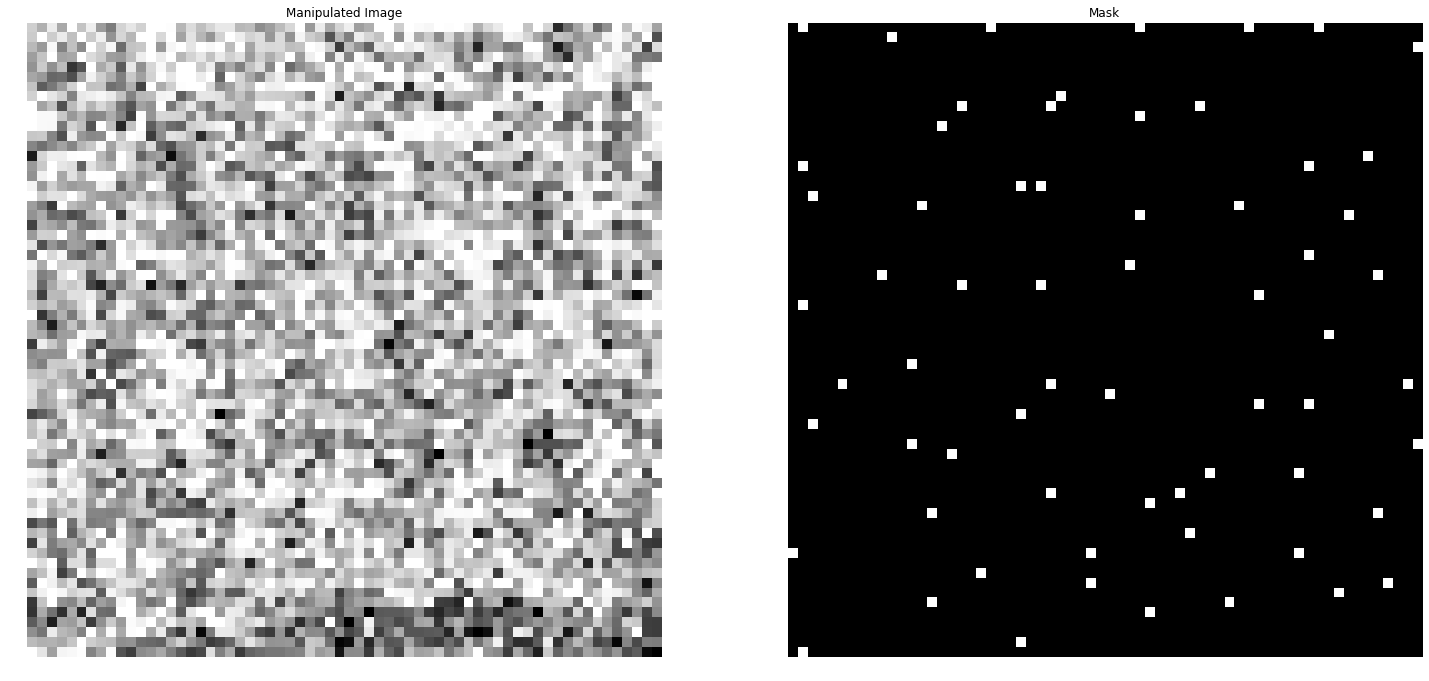

In [12]:
# Load the remaining data as validation data
X_val = imread('data/SEM/train/train.tif')[np.newaxis,3,2500:,:].astype(np.float32)

# We are extracting random patches for training
X_val = extractRandomPatches(X_val,64,256)
X_val = X_val[...,np.newaxis]

# We normalize the data using the same mean and standard deviation as for the training
X_val = normalize(X_val, mean, std)

# 1. Option
Y_val = np.concatenate((X_val.copy(), np.zeros(X_val.shape)), axis=3) 
manipulate_val_data(X_val, Y_val,num_pix=64 , shape=(64, 64))

# 2. Option
#Y_val = np.concatenate((X_val.copy(), np.ones(X_val.shape)), axis=3)

# The validation set is noisy as well:

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(X_val[0,...,0], cmap="gray")
plt.axis('off')
plt.title("Manipulated Image")
plt.subplot(1,2,2)
plt.imshow(Y_val[0,...,1], cmap="gray")
plt.axis('off')
plt.title("Mask")
print(X_val.shape, Y_val.shape)

## Training

In [13]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

W0520 22:51:59.704467 47803376164544 deprecation.py:323] From /home/coreys/Noise2Void/lib/python3.7/site-packages/tensorflow/contrib/distributions/python/ops/sample_stats.py:307: to_double (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0520 22:51:59.744246 47803376164544 deprecation.py:323] From /home/coreys/Noise2Void/lib/python3.7/site-packages/tensorflow/contrib/distributions/python/ops/sample_stats.py:352: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Epoch 1/100
10/10 [==============================] - 10s 985ms/step - loss: 2.2994 - mse: 2.0746 - mae: 1.1651 - val_loss: 3.3211 - val_mse: 1.7070 - val_mae: 1.0232
Epoch 2/100
10/10 [==============================] - 6s 564ms/step - loss: 1.5288 - mse: 1.3553 - mae: 0.9527 - val_loss: 26.3421 - val_mse: 22.1258 - val_mae: 4.0095
Epoch 3/100
10/10 [==============================] - 5s 525ms/step - loss: 1.0655 - mse: 0.8869 - mae: 0.7754 - val_loss: 73.0320 - val_mse: 63.9108 - val_mae: 7.1891
Epoch 4/100
10/10 [==============================] - 6s 610ms/step - loss: 0.8091 - mse: 0.6351 - mae: 0.6551 - val_loss: 33.0203 - val_mse: 27.4346 - val_mae: 4.5376
Epoch 5/100
10/10 [==============================] - 6s 567ms/step - loss: 0.7163 - mse: 0.5231 -

10/10 [==============================] - 5s 518ms/step - loss: 0.5991 - mse: 0.4323 - mae: 0.5407 - val_loss: 0.5275 - val_mse: 0.5090 - val_mae: 0.5833
Epoch 49/100
10/10 [==============================] - 5s 541ms/step - loss: 0.6003 - mse: 0.4284 - mae: 0.5383 - val_loss: 0.5282 - val_mse: 0.4803 - val_mae: 0.5691
Epoch 50/100
10/10 [==============================] - 6s 551ms/step - loss: 0.6005 - mse: 0.4236 - mae: 0.5370 - val_loss: 0.5298 - val_mse: 0.4687 - val_mae: 0.5650
Epoch 51/100
10/10 [==============================] - 5s 505ms/step - loss: 0.6011 - mse: 0.4279 - mae: 0.5380 - val_loss: 0.5259 - val_mse: 0.5197 - val_mae: 0.5942
Epoch 52/100
10/10 [==============================] - 6s 552ms/step - loss: 0.5979 - mse: 0.4303 - mae: 0.5391 - val_loss: 0.5259 - val_mse: 0.5477 - val_mae: 0.6070
Epoch 53/100
10/10 [==============================] - 5s 522ms/step - loss: 0.6004 - mse: 0.4233 - mae: 0.5338 - val_loss: 0.5264 - val_mse: 0.4992 - val_mae: 0.5807
Epoch 54/100
10/1

Epoch 97/100
10/10 [==============================] - 5s 523ms/step - loss: 0.5977 - mse: 0.4152 - mae: 0.5297 - val_loss: 0.5209 - val_mse: 0.5321 - val_mae: 0.5969
Epoch 98/100
10/10 [==============================] - 5s 499ms/step - loss: 0.5941 - mse: 0.4231 - mae: 0.5348 - val_loss: 0.5209 - val_mse: 0.5221 - val_mae: 0.5934
Epoch 99/100
10/10 [==============================] - 5s 461ms/step - loss: 0.5935 - mse: 0.4233 - mae: 0.5349 - val_loss: 0.5211 - val_mse: 0.5360 - val_mae: 0.6027
Epoch 100/100
10/10 [==============================] - 5s 474ms/step - loss: 0.5921 - mse: 0.4299 - mae: 0.5393 - val_loss: 0.5206 - val_mse: 0.5340 - val_mae: 0.6025

Loading network weights from 'weights_best.h5'.


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


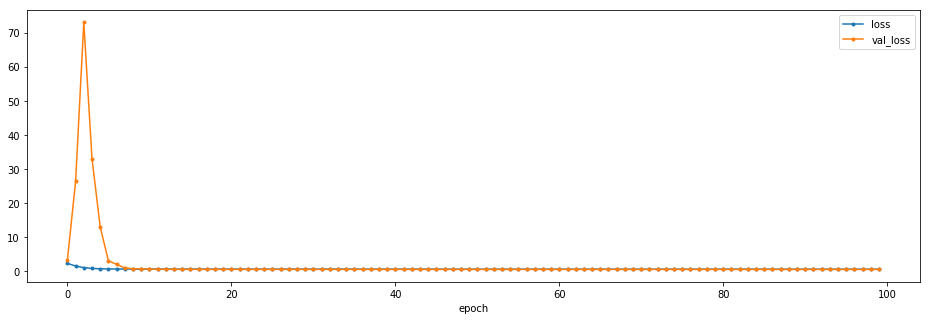

In [14]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'])
plt.show()

## Evaluation

For the evaluation we load the test low-SNR and ground truth data. Since we have simulated low- and high-SNR images via exposure, we have to normalize the values to compute a meaningful PSNR value. The ground truth data has a simulated exposure of 10'000 and the low-SNR data has an exposure of 20. 

In [15]:
 #model.load_weights(name='weights_last.h5')

In [16]:
test_lowSNR = imread('data/SEM/test/test.tif')[:,:,:,np.newaxis]
# normalize data with mean and std of the training data
test_lowSNR = normalize(test_lowSNR, mean, std)

In [17]:
predictions = []
# Denoise all images
for i in range(test_lowSNR.shape[0]):
    predictions.append(denormalize(model.predict(test_lowSNR[i], axes='YXC',normalizer=None ), mean, std))
predictions = np.array(predictions)

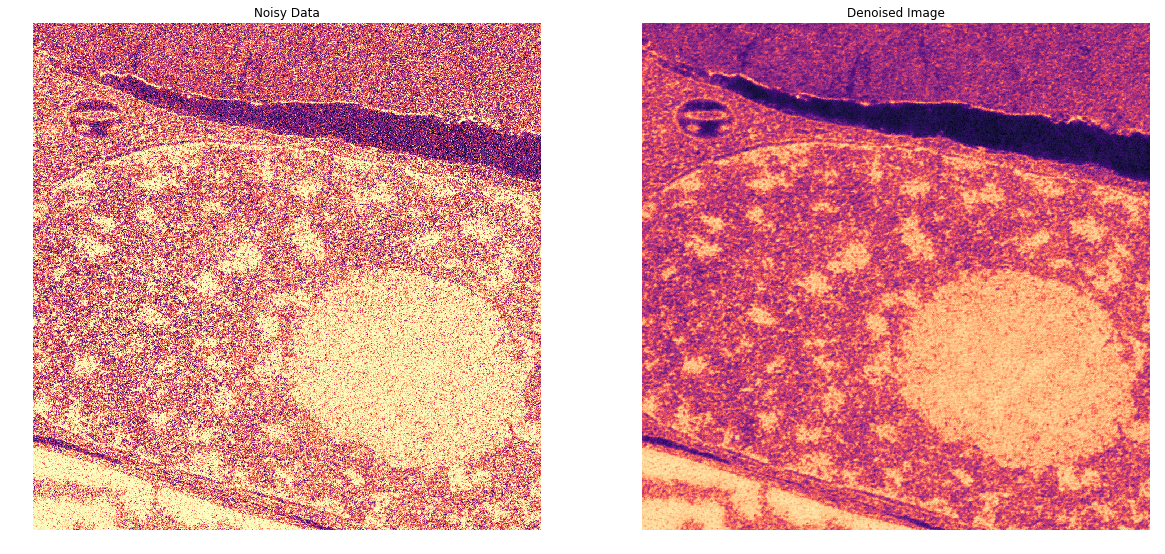

In [20]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,20))
ax2.imshow(predictions[4,600:1500,600:1500,0],cmap="magma")
ax2.axis('off')
ax2.set_title('Denoised Image')
ax1.imshow(test_lowSNR[4,600:1500,600:1500,0],cmap="magma")
ax1.axis('off')
ax1.set_title('Noisy Data')
plt.show()